# Toronto Dwellings Analysis Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions to create a Panel dashboard.

In [2]:
# imports
import panel as pn
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [3]:
# Initialize the Panel Extensions (for Plotly)
pn.extension("plotly")

In [4]:
# Import hvplot after initializing panel extension
import hvplot.pandas

In [5]:
# Read the Mapbox API key
load_dotenv("C:/Users/lendl/Desktop/Jupyter-Workspace/env/.env")
map_box_api = os.getenv("mapbox_api")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [6]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/toronto_neighbourhoods_census_data.csv")
to_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/toronto_neighbourhoods_coordinates.csv")
df_neighbourhood_locations = pd.read_csv(file_path)
df_neighbourhood_locations.set_index("neighbourhood", inplace=True)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

### Global available data

In [7]:
# Calculate the average house value per year
avg_house_value = to_data["average_house_value"].groupby(
    to_data.index).mean()

# Getting the data for Average house value by neighbourhood
avg_house_value_neighbourhood = to_data.groupby([to_data.index, "neighbourhood"])["average_house_value"].mean()
avg_house_value_neighbourhood = avg_house_value_neighbourhood.reset_index()
avg_house_value_neighbourhood["average_house_value"] = avg_house_value_neighbourhood["average_house_value"].astype(int)

# Getting the data from the top 10 expensive neighbourhoods
grp_neighbourhoods_avg_value = to_data.groupby("neighbourhood")["average_house_value"].mean()
top10_avg_value = grp_neighbourhoods_avg_value.nlargest(10).reset_index()

# Fetch the data of all dwelling types per year
dwelling_types_per_neighbourhood = to_data.drop(
    columns=["average_house_value", "shelter_costs_owned", "shelter_costs_rented"])

# Calculate the mean number of dwelling types units per year
dwelling_types_yearly = to_data.iloc[:,1:9].groupby(to_data.index).sum()

# Calculate the average monthly shelter costs for owned and rented dwellings
shelter_costs = to_data[["shelter_costs_owned", "shelter_costs_rented"]].groupby(
    to_data.index).mean()

# Calculate the mean values for each neighborhood
neighbourhoods_avgs = to_data.groupby("neighbourhood").mean()

# Join the average values with the neighbourhood locations
neighbourhood_map_data = pd.concat(
    [
        neighbourhoods_avgs,
        df_neighbourhood_locations
    ], axis=1, join="inner"
).reset_index()

# Fetch the data from all expensive neighbourhoods per year for the sunburst chart
top10_neighbourhoods_per_year = to_data[to_data["neighbourhood"].isin(top10_avg_value["neighbourhood"])].reset_index()

### Panel Visualization Functions

In [8]:
# Define Panel visualization functions
def neighbourhood_map():
    """Neighbourhood Map"""
   
    to_map = px.scatter_mapbox(
        neighbourhood_map_data,
        lon="lon",
        lat="lat",
        color="average_house_value",
        size="average_house_value",
        hover_name="neighbourhood",
        hover_data=[
            'single_detached_house',
            'apartment_five_storeys_plus',
            'movable_dwelling', 
            'semi_detached_house', 
            'row_house', 
            'duplex',
            'apartment_five_storeys_less', 
            'other_house', 
            'average_house_value', 
            'shelter_costs_owned', 
            'shelter_costs_rented', 
            'lat', 
            'lon'
        ],
        zoom=9,
        height=500,
        width=1000,
        title="Average Neighbourhood House Value"
    )
    
    return to_map
        

def create_bar_chart(data, title, xlabel, ylabel, color):
    """
    Create a barplot based in the data argument.
    """
    
    fig = plt.figure(figsize=(4,3))
    bar_chart = data.plot.bar(
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        color=color,
        figsize=(5,3)
    )
    plt.close(fig)
    
    return pn.pane.Matplotlib(fig, tight=True)

def create_line_chart(data, title, xlabel, ylabel, color):
    """
    Create a line chart based in the data argument.
    """
    
    fig = plt.figure()
    line_chart = data.plot.line(
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        color=color,
    )
    plt.close(fig)
    
    return pn.pane.Matplotlib(fig, tight=True)

def average_house_value():
    """Average house values per year."""
    
    fig = plt.figure()
    line_chart = avg_house_value.plot.line(
        title="Average House Value in Toronto",
        xlabel="Year",
        ylabel="Value",
        color="magenta",
    )
    plt.close(fig)
    
    return pn.pane.Matplotlib(fig, tight=True)

def average_value_by_neighbourhood():
    """Average house values by neighbourhood."""
    
    line_plot = avg_house_value_neighbourhood.hvplot.line(
        x="year",
        y="average_house_value",
        groupby="neighbourhood",
        xlabel="Year",
        ylabel="Value",
        title="Average House Value by Neighbourhood",
        height=400,
        width=600
    ).opts(yformatter="%.0f")
        
    return line_plot

def number_dwelling_types():
    """Number of dwelling types per year"""
    
    bar_plot = dwelling_types_per_neighbourhood.hvplot.bar(
        x="year",
        groupby="neighbourhood",
        title="Dwelling Types per Neighbourhood",
        xlabel="Year/Dwelling Type",
        ylabel="Number of Units",
        rot=90,
        height=400,
        width=600
    ).opts(yformatter="%.0f")
    
    return bar_plot

def average_house_value_snapshot():
    """Average house value for all Toronto's neighbourhoods per year."""

    facet_chart = px.bar(
        avg_house_value_neighbourhood,
        x="neighbourhood",
        y="average_house_value",
        color="average_house_value",
        facet_row="year",
        height=800,
        width=900,
        title="Average Neighbourhood House Value per Year"
    )
    
    return facet_chart

def top_most_expensive_neighbourhoods():
    """Top 10 most expensive neighbourhoods."""
    
    bar_plot = top10_avg_value.hvplot.bar(
        x="neighbourhood",
        title="Top 10 Expensive Neighbourhoods in Toronto",
        xlabel="Neighbourhood",
        ylabel="Avg. House Value",
        rot=90,
        height=600,
        width=800,
        color="blue"
    ).opts(yformatter="%.0f")
    
    return bar_plot

def sunburts_cost_analysis():
    """Sunburst chart to conduct a costs analysis of most expensive neighbourhoods in Toronto per year."""
    
    sunburts = px.sunburst(
        top10_neighbourhoods_per_year,
        path=["year", "neighbourhood"],
        color="shelter_costs_owned",
        values="average_house_value",
        color_continuous_scale="RdBu",
        height=600,
        width=1000,
        title="Cost Analysis of Toronto's Top 10 Most Expensive Neighbourhoods per Year"
    )
    
    return sunburts

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [9]:
# Create a Title for the Dashboard
title = pn.Column(
    "## Real Estate Analysis of Toronto from 2001 to 2016",
    width=800
)

# Define a welcome text
welcome_text = pn.pane.Markdown(
    "#### This dashboard presents a visual analysis of historical house values, dwelling types, and costs per neighbourhood in Toronto, Ontario from 2001 to 2016."
)

# Create a tab layout for the Dashboard
tabs = pn.Tabs(
    # First Tab
    (
        "Welcome", 
        pn.Column(
            welcome_text,
            neighbourhood_map()
        )
    ),
    # Second Tab
    (
        "Yearly Market Analysis",
        pn.Column(
            pn.Row(
                create_bar_chart(
                    dwelling_types_yearly.loc[2001], 
                    "Dwelling Types in Toronto in 2001", 
                    "Dwelling Type", 
                    "Number of Units",
                    "red"
                ),
                create_bar_chart(
                    dwelling_types_yearly.loc[2006], 
                    "Dwelling Types in Toronto in 2006", 
                    "Dwelling Type", 
                    "Number of Units",
                    "blue"
                )
            ),
            pn.Row(
                create_bar_chart(
                    dwelling_types_yearly.loc[2011], 
                    "Dwelling Types in Toronto in 2011", 
                    "Dwelling Type", 
                    "Number of Units",
                    "gold"
                ),
                create_bar_chart(
                    dwelling_types_yearly.loc[2016], 
                    "Dwelling Types in Toronto in 2016", 
                    "Dwelling Type", 
                    "Number of Units",
                    "magenta"
                )
            )
        )
    ),
    # Third Tab
    (
        "Shelter Costs vs. House Value",
        pn.Column(
            create_line_chart(
                shelter_costs["shelter_costs_owned"],
                "Average Monthly Shelter Costs for Owned Dwellings in Toronto", 
                "Year",
                "Avg Monthly Shelter Costs",
                "blue"
            ),
            create_line_chart(
                shelter_costs["shelter_costs_rented"], 
                "Average Monthly Shelter Costs for Rented Dwellings in Toronto", 
                "Year",
                "Avg Monthly Shelter Costs",
                "gold"
            ),
            average_house_value()
        )
    ),
    # Fourth Tab
    (
        "Neighbourhood Analysis",
        pn.Row(
            pn.Column(
                average_value_by_neighbourhood,
                number_dwelling_types
            ),
            average_house_value_snapshot
        )
    ),
    # Fifth Tab
    (
        "Top Expensive Neighbourhoods",
        pn.Row(
            top_most_expensive_neighbourhoods,
            sunburts_cost_analysis
        )
    )
)


# Create the main Dashboard
dashboard = pn.Column(
    title,
    tabs
)

## Serve the Panel Dashboard

Column
    [0] Column(width=800)
        [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
        [1] Column
            [0] Row
                [0] Matplotlib(Figure, tight=True)
                [1] Matplotlib(Figure, tight=True)
            [1] Row
                [0] Matplotlib(Figure, tight=True)
                [1] Matplotlib(Figure, tight=True)
        [2] Column
            [0] Matplotlib(Figure, tight=True)
            [1] Matplotlib(Figure, tight=True)
            [2] Matplotlib(Figure, tight=True)
        [3] Row
            [0] Column
                [0] Column
                    [0] Column()
                    [1] Row
                        [0] Row(name='interactive00804')
                            [0] HoloViews(DynamicMap, name='interactive00804')
                            [1] Column
                                [0] WidgetBox
                                    [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                                [1] VSpacer()
                [1] Column
                    [0] Column()
                    [1] Row
                        [0] Row(name='interactive00846')
                            [0] HoloViews(DynamicMap, name='interactive00846')
                            [1] Column
                                [0] WidgetBox
                                    [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                                [1] VSpacer()
            [1] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure, name='interactive00895')
        [4] Row
            [0] Column
                [0] Column()
                [1] Row
                    [0] HoloViews(Bars, name='interactive00902')
            [1] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure, name='interactive01011')
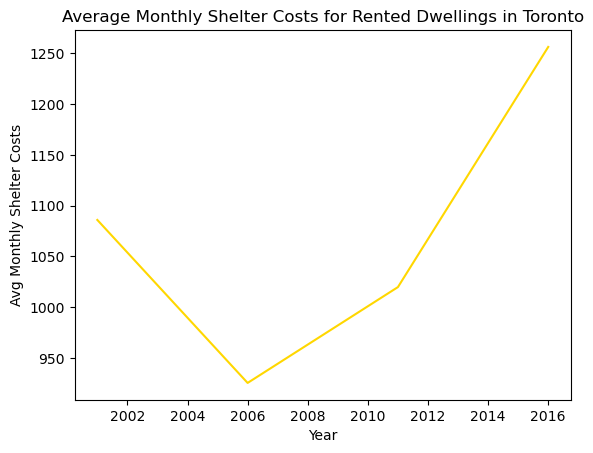
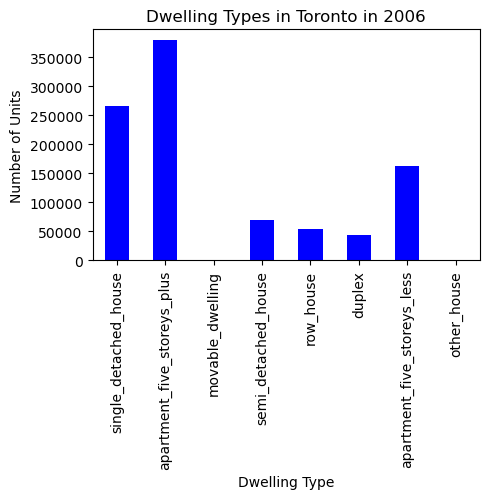
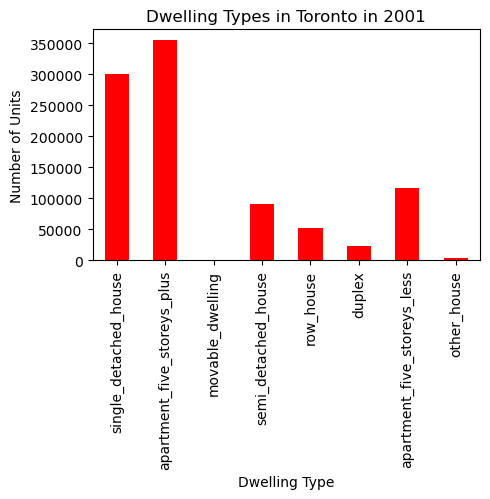
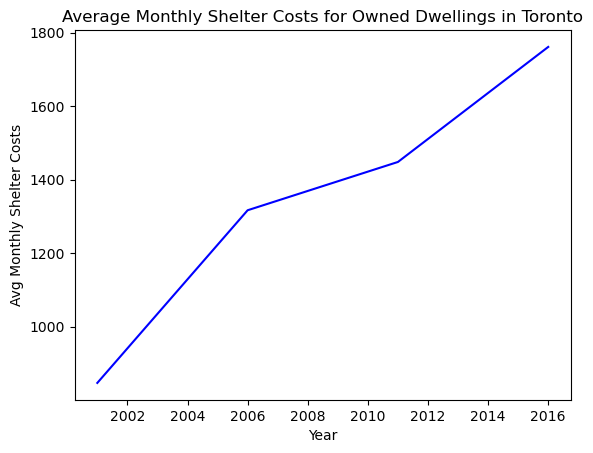
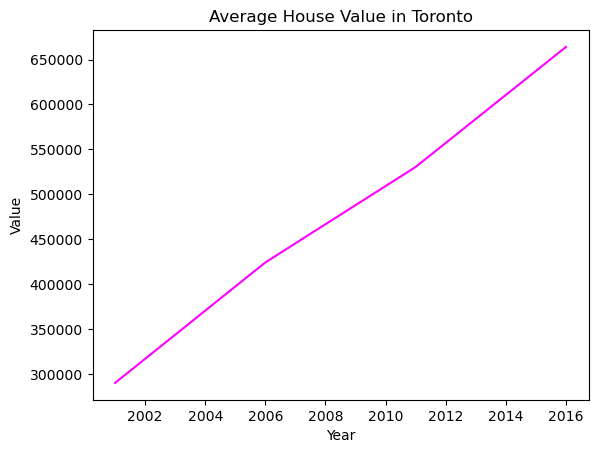
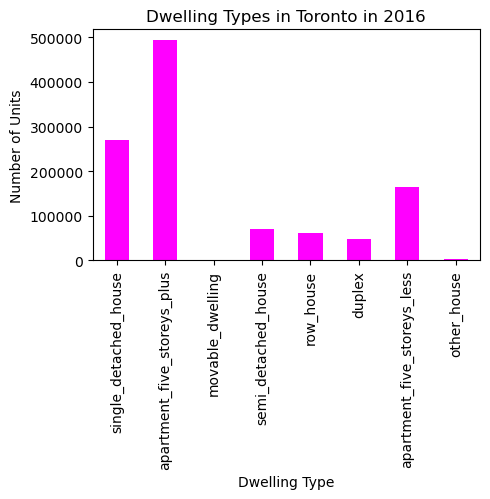
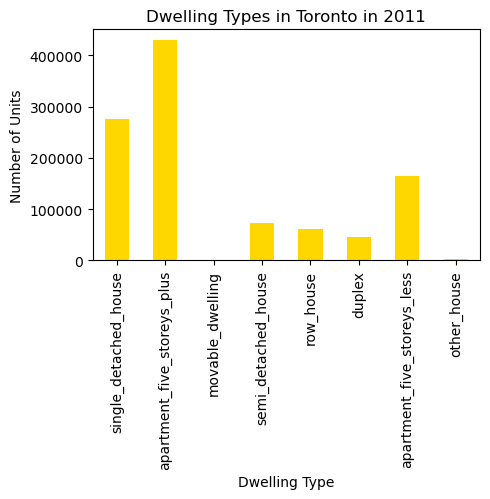

In [10]:
dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [11]:
# neighbourhood_map().show()

In [12]:
# create_bar_chart(data, title, xlabel, ylabel, color)

# # Bar chart for 2001
# create_bar_chart(df_dwelling_units.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red")

# # Bar chart for 2006
# create_bar_chart(df_dwelling_units.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue")

# # Bar chart for 2011
# create_bar_chart(df_dwelling_units.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "orange")

# # Bar chart for 2016
# create_bar_chart(df_dwelling_units.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta")

In [13]:
# create_line_chart(data, title, xlabel, ylabel, color)

# # Line chart for owned dwellings
# create_line_chart(df_avg_costs["shelter_costs_owned"], "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue")

# # Line chart for rented dwellings
# create_line_chart(df_avg_costs["shelter_costs_rented"], "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange")

In [14]:
# average_house_value()

In [15]:
# average_value_by_neighbourhood()

In [16]:
# number_dwelling_types()

In [17]:
# average_house_value_snapshot()

In [18]:
# top_most_expensive_neighbourhoods()

In [19]:
# sunburts_cost_analysis()